In [72]:
#General imports
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import os

In [11]:
#Custom files imports
import config
from feature_extractor import FeatureExtrator

In [16]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.nn import CosineSimilarity
import torch

In [97]:
results = pd.DataFrame(columns=['Model','Method','Score'])
dir_list = next(os.walk(config.features_data_dir))[1]

In [5]:
df_source = pd.DataFrame()
features = []
for d in dir_list:
    csv_path = config.features_data_dir + d + "\scores.csv"
    df = pd.read_csv(csv_path)
    df['language'] = d
    df_source = df_source.append(df)
    tensor = torch.load(config.features_data_dir + d + "\\tensor.pt")
    features.append(tensor)
features = tf.concat(features,0)
    

In [6]:
df_source.head()

,Unnamed: 0,source,reference,translation,z-score,avg-score,annotators,language
0,0,Uchopíte pak zbraň mezi své předloktí a rameno...,you will then grab the weapon between your for...,you then grasp the gun between your forearm an...,-0.675383,60.000000,3,cs-en
1,1,"Ale je-li New York změna, pak je to také znovu...",but if new york is changed then it s also a r...,but if new york is change it is also reinvent...,-0.829403,44.000000,2,cs-en
2,2,"Dlouho a intenzivně jsem během léta přemýšlel,...",i have been thinking over and over again over ...,i have thought long and hard over the course o...,0.803185,96.500000,2,cs-en
3,3,"Najdou si jiný způsob, jak někde podvádět.",they find another way to cheat somewhere,they will find another way how to defraud others,0.563149,90.500000,2,cs-en
4,4,Zpráva o výměně v čele prezidentovy administra...,the report on the replacement of the president...,the news of the replacement at the top of the ...,0.021549,74.666667,3,cs-en


In [73]:
sims = []
cos =CosineSimilarity(dim=0)
for f in features:
    t1,t2 = tf.split(f, num_or_size_splits=2, axis=0)
    t1 = F.normalize(torch.Tensor(np.array(t1)), p=2,dim=0)
    t2 = F.normalize(torch.Tensor(np.array(t2)), p=2,dim=0)
    sims.append(cos(t1,t2))

In [75]:
df_source['baseline_score'] = np.array(sims)
df_source.head(5)

,Unnamed: 0,source,reference,translation,z-score,avg-score,annotators,language,similarity,baseline_score,dnn_score
0,0,Uchopíte pak zbraň mezi své předloktí a rameno...,you will then grab the weapon between your for...,you then grasp the gun between your forearm an...,-0.675383,60.000000,3,cs-en,0.961775,0.961775,62.912018
1,1,"Ale je-li New York změna, pak je to také znovu...",but if new york is changed then it s also a r...,but if new york is change it is also reinvent...,-0.829403,44.000000,2,cs-en,0.963354,0.963355,65.189987
2,2,"Dlouho a intenzivně jsem během léta přemýšlel,...",i have been thinking over and over again over ...,i have thought long and hard over the course o...,0.803185,96.500000,2,cs-en,0.848682,0.848681,109.193130
3,3,"Najdou si jiný způsob, jak někde podvádět.",they find another way to cheat somewhere,they will find another way how to defraud others,0.563149,90.500000,2,cs-en,0.860908,0.860908,91.115807
4,4,Zpráva o výměně v čele prezidentovy administra...,the report on the replacement of the president...,the news of the replacement at the top of the ...,0.021549,74.666667,3,cs-en,0.822409,0.822410,77.781845


In [98]:
corr = df_source[['avg-score','baseline_score']].corr()
results = results.append({'Model':'baseline','Method': 'Pearson','Score': corr[corr.index == 'avg-score']['baseline_score'][0]},ignore_index=True)

In [99]:
corr = df_source[['avg-score','baseline_score','baseline-zscore']].corr(method='kendall')
results = results.append({'Model':'baseline','Method': 'Kendall Tau','Score': corr[corr.index == 'avg-score']['baseline_score'][0]},ignore_index=True)

In [55]:
X = np.array(features)
y = df_source['avg-score']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [56]:
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
      ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [57]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

In [58]:
dnn_model = build_and_compile_model(normalizer)

[<tf.Tensor 'Placeholder:0' shape=(None, 1536) dtype=float32>]
[<tf.Tensor 'Placeholder:0' shape=(None, 128) dtype=float32>]
[<tf.Tensor 'Placeholder:0' shape=(None, 64) dtype=float32>]
[<tf.Tensor 'Placeholder:0' shape=(None, 64) dtype=float32>]


In [59]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1536)              3073      
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 212,290
Trainable params: 209,217
Non-trainable params: 3,073
_________________________________________________________________


In [60]:
%%time
history = dnn_model.fit(
   X_train, y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

[<tf.Tensor 'sequential/normalization_1/truediv:0' shape=(None, 1536) dtype=float32>]
[<tf.Tensor 'sequential/dense/Relu:0' shape=(None, 128) dtype=float32>]
[<tf.Tensor 'sequential/dense_1/Relu:0' shape=(None, 64) dtype=float32>]
[<tf.Tensor 'sequential/dense_2/Relu:0' shape=(None, 64) dtype=float32>]
[<tf.Tensor 'sequential/normalization_1/truediv:0' shape=(None, 1536) dtype=float32>]
[<tf.Tensor 'sequential/dense/Relu:0' shape=(None, 128) dtype=float32>]
[<tf.Tensor 'sequential/dense_1/Relu:0' shape=(None, 64) dtype=float32>]
[<tf.Tensor 'sequential/dense_2/Relu:0' shape=(None, 64) dtype=float32>]
[<tf.Tensor 'sequential/normalization_1/truediv:0' shape=(None, 1536) dtype=float32>]
[<tf.Tensor 'sequential/dense/Relu:0' shape=(None, 128) dtype=float32>]
[<tf.Tensor 'sequential/dense_1/Relu:0' shape=(None, 64) dtype=float32>]
[<tf.Tensor 'sequential/dense_2/Relu:0' shape=(None, 64) dtype=float32>]
Wall time: 5min 21s


In [63]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
def plot_loss(history):
    figure(figsize=(8, 6), dpi=80)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 50])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

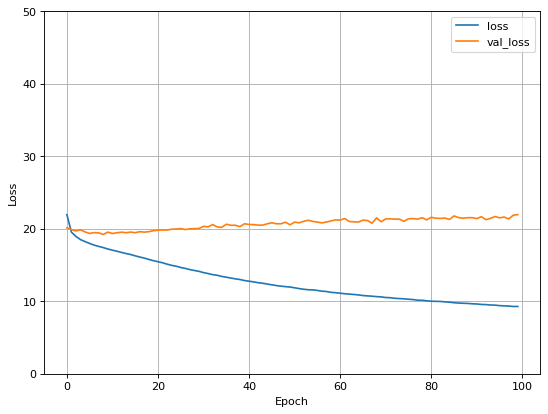

In [64]:
plot_loss(history)

In [65]:
dnn_model.evaluate(X_test,y_test)

967/967 [==============================] - 2s 2ms/step - loss: 21.7201


21.72014045715332

In [71]:
dnn_model.save("dnn_model")

[<tf.Tensor 'sequential/normalization_1/truediv:0' shape=(None, 1536) dtype=float32>]
[<tf.Tensor 'sequential/dense/Relu:0' shape=(None, 128) dtype=float32>]
[<tf.Tensor 'sequential/dense_1/Relu:0' shape=(None, 64) dtype=float32>]
[<tf.Tensor 'sequential/dense_2/Relu:0' shape=(None, 64) dtype=float32>]
[<tf.Tensor 'normalization_1/truediv:0' shape=(None, 1536) dtype=float32>]
[<tf.Tensor 'dense/StatefulPartitionedCall:0' shape=(None, 128) dtype=float32>]
[<tf.Tensor 'dense_1/StatefulPartitionedCall:0' shape=(None, 64) dtype=float32>]
[<tf.Tensor 'dense_2/StatefulPartitionedCall:0' shape=(None, 64) dtype=float32>]
[<tf.Tensor 'normalization_1/truediv:0' shape=(None, 1536) dtype=float32>]
[<tf.Tensor 'dense/StatefulPartitionedCall:0' shape=(None, 128) dtype=float32>]
[<tf.Tensor 'dense_1/StatefulPartitionedCall:0' shape=(None, 64) dtype=float32>]
[<tf.Tensor 'dense_2/StatefulPartitionedCall:0' shape=(None, 64) dtype=float32>]
[<tf.Tensor 'normalization_1/truediv:0' shape=(None, 1536) dty

In [66]:
df_source['dnn_score'] = dnn_model.predict(X)

[<tf.Tensor 'sequential/normalization_1/truediv:0' shape=(None, 1536) dtype=float32>]
[<tf.Tensor 'sequential/dense/Relu:0' shape=(None, 128) dtype=float32>]
[<tf.Tensor 'sequential/dense_1/Relu:0' shape=(None, 64) dtype=float32>]
[<tf.Tensor 'sequential/dense_2/Relu:0' shape=(None, 64) dtype=float32>]


In [100]:
corr = df_source[['avg-score','dnn_score']].corr()
results = results.append({'Model':'dnn','Method': 'Pearson','Score': corr[corr.index == 'avg-score']['dnn_score'][0]},ignore_index=True)

In [101]:
corr = df_source[['avg-score','dnn_score']].corr(method='kendall')
results = results.append({'Model':'dnn','Method': 'Kendall Tau','Score': corr[corr.index == 'avg-score']['dnn_score'][0]},ignore_index=True)

In [102]:
results

,Model,Method,Score
0,baseline,Pearson,0.399703
1,baseline,Kendall Tau,0.284507
2,dnn,Pearson,0.623123
3,dnn,Kendall Tau,0.448801
